In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image
#from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR


In [2]:
if not os.path.exists('content/drive/sample_data'):
    os.mkdir('multichanneldata')

In [3]:
import os.path
import shutil
from google.colab import drive

if not os.path.exists('/content/gdrive'):
  drive.mount('/content/gdrive')
  
DOWNLOAD_LOCATION = '/content/multichanneldata'
DRIVE_DATASET_FILE = '/content/gdrive/My Drive/data/multichannel_data.zip' #adjust path/name of dataset which is in your G-drive

shutil.copy(DRIVE_DATASET_FILE,DOWNLOAD_LOCATION)

print('Successfully downloaded the dataset')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Successfully downloaded the dataset


In [4]:
!unzip multichanneldata/multichannel_data.zip -d multichanneldata/GAN_data # adjust the dataset filename which you have downloaded from Google drive

Archive:  multichanneldata/multichannel_data.zip
  inflating: multichanneldata/GAN_data/multichannel_data/spectralenergy_iDAS16043_160321000021_ch1200_1300.png  
  inflating: multichanneldata/GAN_data/multichannel_data/spectralenergy_iDAS16043_160321000021_ch1200_13000.png  
  inflating: multichanneldata/GAN_data/multichannel_data/spectralenergy_iDAS16043_160321000021_ch1200_1300test.png  
  inflating: multichanneldata/GAN_data/multichannel_data/spectralenergy_iDAS16043_160321000021_ch300_400.png  
  inflating: multichanneldata/GAN_data/multichannel_data/spectralenergy_iDAS16043_160321000021_ch300_4001.png  
  inflating: multichanneldata/GAN_data/multichannel_data/spectralenergy_iDAS16043_160321000021_ch300_400test.png  
  inflating: multichanneldata/GAN_data/multichannel_data/spectralenergy_iDAS16043_160321000051_ch1200_1300.png  
  inflating: multichanneldata/GAN_data/multichannel_data/spectralenergy_iDAS16043_160321000051_ch1200_13002.png  
  inflating: multichanneldata/GAN_data/mul

In [5]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [17]:
# Root directory for dataset
dataroot = "/content/multichanneldata/GAN_data"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

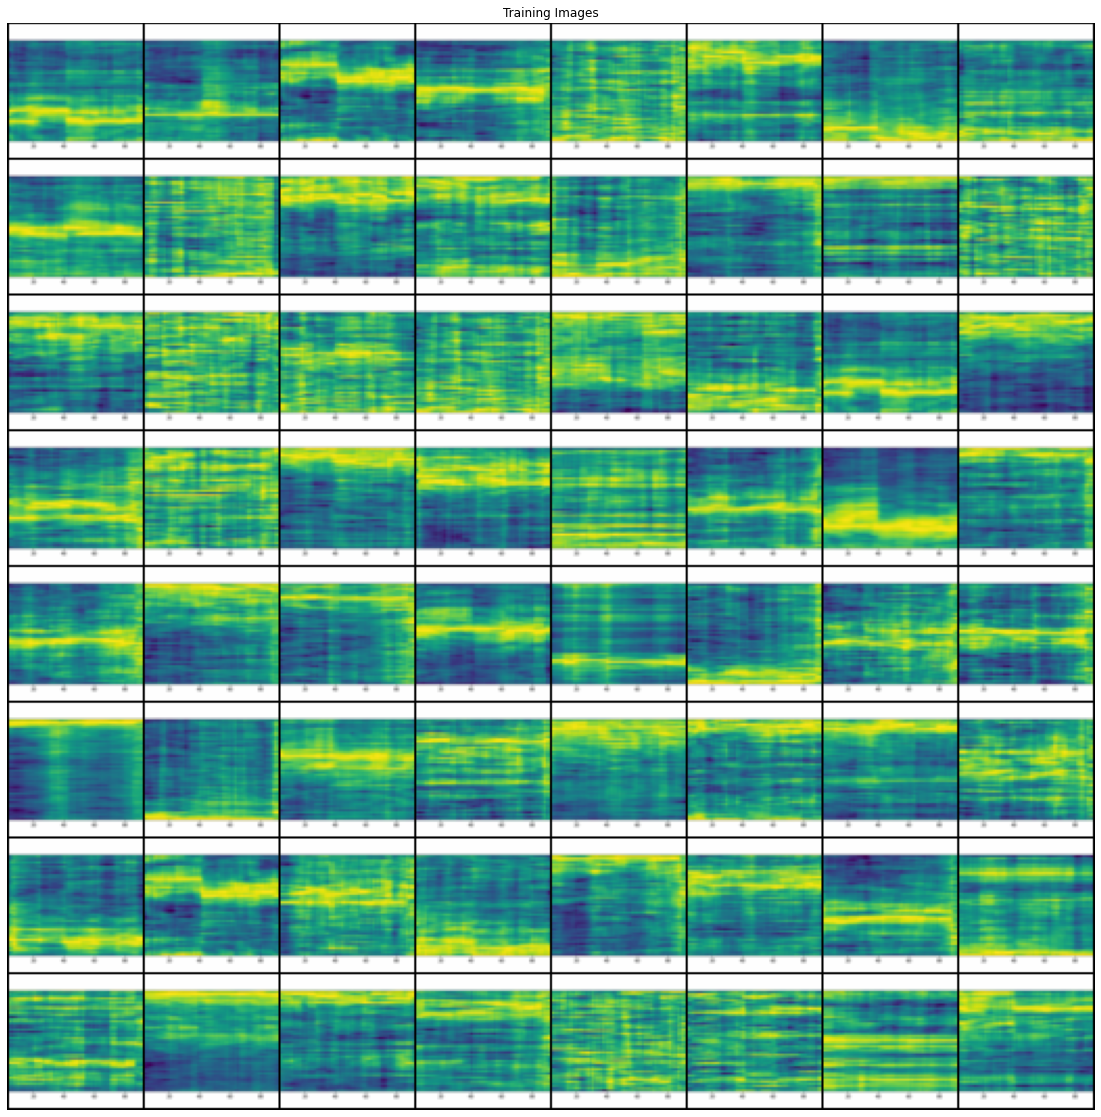

In [18]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [14]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
if not os.path.exists('content/drive/sampledata'):
    os.mkdir('fakeimagedata')


In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
fake_image=[]
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                images = fake.to("cpu").clone().detach()
                images = images.numpy().transpose(0, 2, 3, 1)
                for i_image in range(fake.size(0)):
                  save_image(fake[i_image, :, :, :], os.path.join('fakeimagedata', f'image_{iters+i_image:05d}.png'))
                #for num, image in enumerate(torch.split(fake, 1)):
                  #save_image(image, "{}.jpg".format(num))

            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            fake_image.append(fake)


        iters += 1


Starting Training Loop...
[0/200][0/24]	Loss_D: 0.0137	Loss_G: 6.6407	D(x): 0.9970	D(G(z)): 0.0106 / 0.0015
[1/200][0/24]	Loss_D: 0.0250	Loss_G: 7.3932	D(x): 0.9972	D(G(z)): 0.0219 / 0.0007
[2/200][0/24]	Loss_D: 0.0120	Loss_G: 6.5485	D(x): 0.9971	D(G(z)): 0.0091 / 0.0015
[3/200][0/24]	Loss_D: 0.0131	Loss_G: 6.4641	D(x): 0.9982	D(G(z)): 0.0112 / 0.0017
[4/200][0/24]	Loss_D: 0.0097	Loss_G: 6.3441	D(x): 0.9982	D(G(z)): 0.0079 / 0.0019
[5/200][0/24]	Loss_D: 0.0091	Loss_G: 6.5592	D(x): 0.9983	D(G(z)): 0.0074 / 0.0015
[6/200][0/24]	Loss_D: 0.0037	Loss_G: 7.0118	D(x): 0.9986	D(G(z)): 0.0023 / 0.0010
[7/200][0/24]	Loss_D: 0.0059	Loss_G: 6.6155	D(x): 0.9989	D(G(z)): 0.0048 / 0.0014
[8/200][0/24]	Loss_D: 0.0035	Loss_G: 7.1223	D(x): 0.9980	D(G(z)): 0.0016 / 0.0008
[9/200][0/24]	Loss_D: 0.0042	Loss_G: 6.7009	D(x): 0.9991	D(G(z)): 0.0034 / 0.0013
[10/200][0/24]	Loss_D: 0.7861	Loss_G: 6.7938	D(x): 0.9898	D(G(z)): 0.0025 / 0.0012
[11/200][0/24]	Loss_D: 0.0021	Loss_G: 7.2061	D(x): 0.9993	D(G(z)): 0.00

In [ ]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
#imgage_list=[]
#fixed_noise = torch.randn(64, nz, 1, 1, device=device)

len(fake_image)
      

11

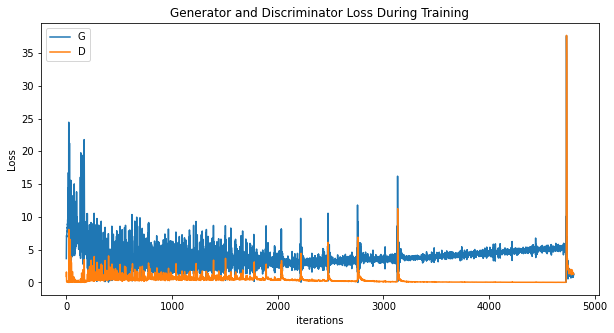

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
for i in fake_image:
  print(i)
  print(i.shape)

tensor([[[[ 3.6996e-02, -8.8253e-02, -3.8636e-02,  ..., -1.2038e-01,
           -4.4636e-02,  1.2795e-02],
          [-2.5730e-02, -5.3761e-02,  1.3077e-02,  ..., -5.3718e-02,
            5.7682e-02,  6.5352e-03],
          [ 3.8524e-02, -2.1765e-01,  1.2659e-02,  ..., -3.0631e-03,
           -3.8741e-02,  2.3197e-02],
          ...,
          [ 4.1275e-02,  6.1226e-02,  5.1176e-02,  ..., -1.1634e-01,
           -7.2050e-02,  2.9373e-02],
          [ 6.3894e-02, -7.3351e-02, -1.2424e-01,  ..., -6.0604e-02,
           -9.2919e-03,  6.9929e-02],
          [ 1.5391e-03,  9.5891e-03, -6.0663e-02,  ...,  6.6171e-02,
           -1.0835e-01,  7.1591e-02]],

         [[-6.5428e-02,  5.1062e-02,  6.1918e-03,  ...,  2.6551e-02,
           -2.8794e-02,  7.8133e-03],
          [-4.5763e-02,  2.1508e-01, -1.4455e-03,  ..., -1.5474e-02,
           -1.0600e-01,  7.6583e-02],
          [-2.8510e-02, -2.9784e-02, -1.9777e-01,  ...,  7.6547e-03,
           -1.9742e-01,  3.6652e-02],
          ...,
     

In [ ]:
img_list[0]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5296,  ..., 0.5050, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.5107,  ..., 0.5505, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.4690,  ..., 0.5069, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.5001,  ..., 0.5032, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5247,  ..., 0.4548, 0.0000, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


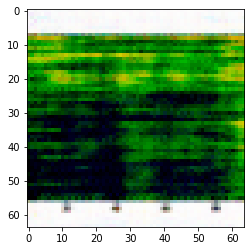

In [ ]:
fake_image[-1]
images = fake_image[-1].numpy().transpose(0, 2, 3, 1)
images
len(images)
images[0].shape
img=images[0]
plt.imshow((img))
img.shape

plt.imshow(img, vmin=0, vmax=255)

In [ ]:
print(len(img_list))
for i in img_list:
  print(i.shape)



11
torch.Size([3, 530, 530])
torch.Size([3, 530, 530])
torch.Size([3, 530, 530])
torch.Size([3, 530, 530])
torch.Size([3, 530, 530])
torch.Size([3, 530, 530])
torch.Size([3, 530, 530])
torch.Size([3, 530, 530])
torch.Size([3, 530, 530])
torch.Size([3, 530, 530])
torch.Size([3, 530, 530])


torch.Size([64, 3, 64, 64])
torch.Size([3, 530, 530])


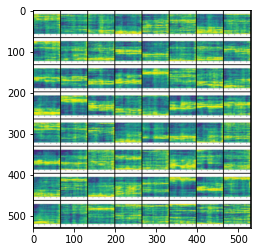

In [ ]:
print(fake_image[-1].shape)

t=img_list[-1].shape
print(t)
x=np.transpose(img_list[-1],(1,2,0))
x.shape
plt.imshow(x, vmin=0, vmax=255)

In [ ]:
import shutil 
shutil.make_archive('images', 'zip', '/content/testfakedata')

'/content/images.zip'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

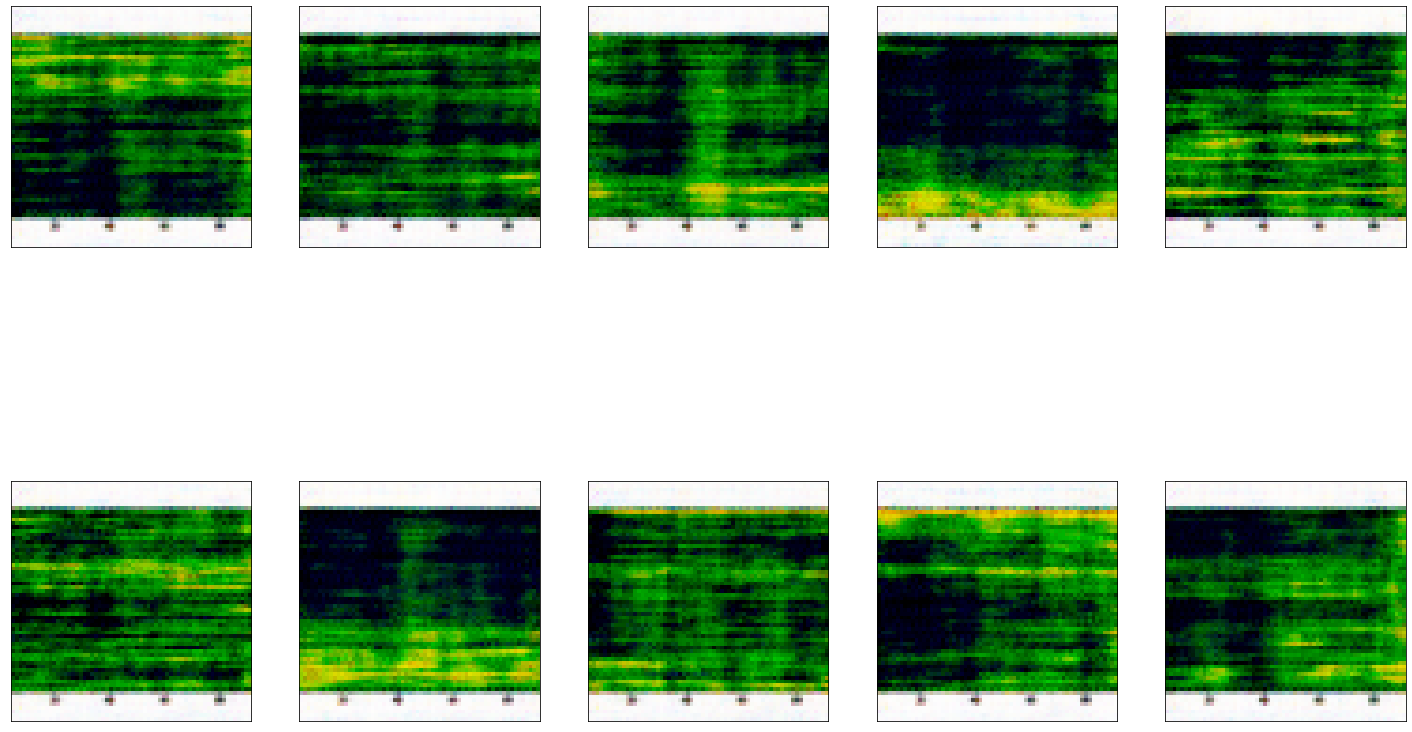

In [ ]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i, j in enumerate(images[:10]):
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    plt.imshow(j)
    #plt.imshow(j.astype('uint8'))

torch.Size([3, 530, 530])


torch.Size([530, 530, 3])

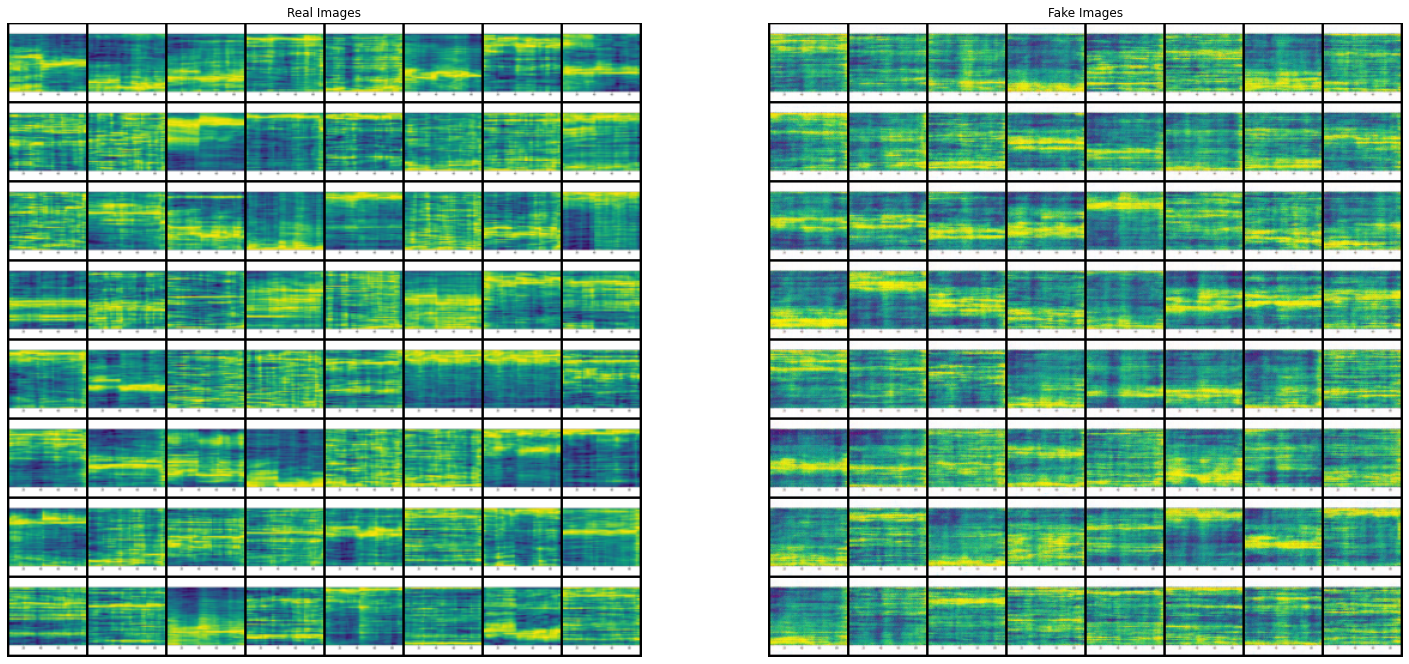

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
img=np.transpose(img_list[-1],(1,2,0))
len(img)

530

In [ ]:
plt.show()

In [ ]:
len(img_list)
img_list[0].shape

torch.Size([3, 530, 530])

In [ ]:
for i in img_list:
  print(i)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5309,  ..., 0.5061, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.5116,  ..., 0.5516, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.4701,  ..., 0.5079, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.5009,  ..., 0.5043, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5259,  ..., 0.4559, 0.0000, 0.

In [ ]:
im_batch_size = 50
n_images=100
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('data', f'image_{i_batch+i_image:05d}.png'))

NameError: ignored

In [ ]:
import shutil 
shutil.make_archive('images', 'zip', '/content/data')

'/content/images.zip'

In [ ]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i, j in enumerate(images[:10]):
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    plt.imshow(j)

NameError: ignored